# Data, Transformaciones

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import torch
from torch import nn, optim
from torch.nn import functional as F
from torchvision import transforms as T
from torch.utils.data import DataLoader, Dataset, random_split

import PIL
from PIL import Image


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


data

In [ ]:
PATH = '/content/drive/MyDrive/Training_SM/Training_Unet'
TRAIN_PATH = '/content/drive/MyDrive/Training_SM/Training_Unet/Imagenes'
TRAIN_MASKS_PATH = '/content/drive/MyDrive/Training_SM/Training_Unet/Mask'
TEST_PATH = '/content/drive/MyDrive/Training_SM/Training_Unet/Type_1_test'

In [ ]:
IMG_MASK = os.listdir(TRAIN_MASKS_PATH)
IMG_IMG = os.listdir(TRAIN_PATH)
print(len(IMG_MASK))
print(len(IMG_IMG))

1050
1050


In [ ]:
class Colposcopia_Dataset(Dataset):
    def __init__(self, data, masks=None, img_transforms=None, mask_transforms=None):
        '''
        data - train data path
        masks - train masks path
        '''
        self.train_data = data
        self.train_masks = masks
        self.img_transforms = img_transforms
        self.mask_transforms = mask_transforms
        self.images = sorted(os.listdir(self.train_data))
        self.masks = sorted(os.listdir(self.train_masks))
    def __len__(self):
        if self.train_masks is not None:
            assert len(self.images)==len(self.masks), 'not the same number of images and masks'
        return len(self.images)
    def __getitem__(self, idx):
        image_name = os.path.join(self.train_data, self.images[idx])
        img = Image.open(image_name)
        trans = T.ToTensor()
        if self.img_transforms is not None:
            img = self.img_transforms(img)
        else:
            img =trans(img)

        if self.train_masks is not None:
            mask_name = os.path.join(self.train_masks, self.masks[idx])
            mask = Image.open(mask_name)
            if self.mask_transforms is not None:
                mask = self.mask_transforms(mask)
            else:
                mask = trans(mask)
            mask_max = mask.max().item()
            mask /= mask_max
        else:
            return img
        return img, mask

transformaciones

In [ ]:
transform_data = T.Compose([
                 T.Resize([224,224]),
                 T.ToTensor()])

In [ ]:
transform_data_gray = T.Compose([
                 T.Resize([224,224]),
                 T.Grayscale(num_output_channels=1),
                 T.ToTensor()])

In [ ]:
full_dataset = Colposcopia_Dataset(TRAIN_PATH,
                           TRAIN_MASKS_PATH,
                           img_transforms=transform_data,
                           mask_transforms=transform_data_gray)

In [ ]:
BATCH_SIZE = 3
TRAIN_SIZE = int(len(full_dataset)*0.8)
VAL_SIZE = len(full_dataset)-TRAIN_SIZE

print(TRAIN_SIZE,VAL_SIZE)

train_dataset, val_dataset = random_split(full_dataset, [TRAIN_SIZE, VAL_SIZE])
print(len(train_dataset), len(val_dataset))


train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

840 210
840 210


In [ ]:
imgs, masks = next(iter(train_loader))
print(imgs.shape, masks.shape)

torch.Size([3, 3, 224, 224]) torch.Size([3, 1, 224, 224])


In [ ]:
for i, (x, y) in enumerate(train_loader):
    print(i, x.shape, y.shape)
    if i==9: break

0 torch.Size([3, 3, 224, 224]) torch.Size([3, 1, 224, 224])
1 torch.Size([3, 3, 224, 224]) torch.Size([3, 1, 224, 224])
2 torch.Size([3, 3, 224, 224]) torch.Size([3, 1, 224, 224])
3 torch.Size([3, 3, 224, 224]) torch.Size([3, 1, 224, 224])
4 torch.Size([3, 3, 224, 224]) torch.Size([3, 1, 224, 224])
5 torch.Size([3, 3, 224, 224]) torch.Size([3, 1, 224, 224])
6 torch.Size([3, 3, 224, 224]) torch.Size([3, 1, 224, 224])
7 torch.Size([3, 3, 224, 224]) torch.Size([3, 1, 224, 224])
8 torch.Size([3, 3, 224, 224]) torch.Size([3, 1, 224, 224])
9 torch.Size([3, 3, 224, 224]) torch.Size([3, 1, 224, 224])


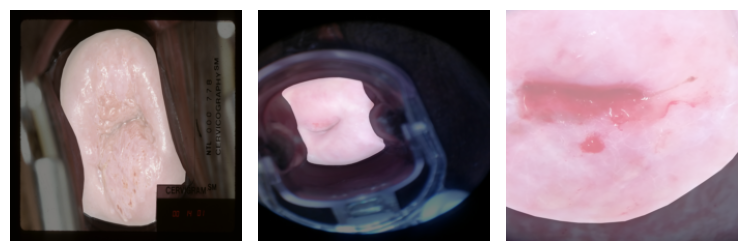

In [ ]:
imgs, masks = next(iter(train_loader))
def plot_mini_bacth(imgs,masks):
    plt.figure(figsize=(20,10))
    for i in range (BATCH_SIZE):
      plt.subplot(4, 8, i+1)
      img = imgs[i,...].permute(1,2,0).numpy()
      mask = masks[i,...].permute(1,2,0).numpy()
      plt.imshow(img)
      plt.imshow(mask,'gray',alpha = 0.5)  #alpha controlla opacidad
      plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_mini_bacth(imgs,masks)


# modelo 1

In [ ]:
!pip install git+https://github.com/qubvel/segmentation_models.pytorch

  Cloning https://github.com/qubvel/segmentation_models.pytorch to /tmp/pip-req-build-vimt12m9
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/segmentation_models.pytorch /tmp/pip-req-build-vimt12m9
  Resolved https://github.com/qubvel/segmentation_models.pytorch to commit 6db76a1106426ac5b55f39fba68168f3bccae7f8
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 27.1 MB/s eta 0:00:00
  Created wheel for segmentation-models-pytorch: filename=segmentation_models_pytorch-0.3.3-py3-none-any.whl size=10

In [ ]:
import torch
import segmentation_models_pytorch as smp

In [ ]:
#resnext50_32x4d, mit_b2, timm-gernet_s, efficientnet-b3, mobilenet_v2, resnet152, vgg13
ENCODER = 'resnet101'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'softmax'

# create segmentation model with pretrained encoder
#Decoders= PAN, PSPNet, MAnet, Linknet, FPN, DeepLabV3, DeepLabV3Plus, Unet
model =smp.FPN(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=2,
    activation=ACTIVATION,
)


# Metricas

In [ ]:
def accuracy(model, loader):
    correct = 0
    intersection = 0
    denom = 0
    union = 0
    total = 0
    cost = 0.
    model = model.to(device=device)
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype = torch.float32)
            y = y.to(device=device, dtype = torch.long).squeeze(1)
            scores = model(x)
            cost += (F.cross_entropy(scores, y)).item()
            # standard accuracy not optimal
            preds = torch.argmax(scores, dim=1)
            correct += (preds == y).sum()
            total += torch.numel(preds)
            #dice coefficient
            intersection += (preds*y).sum()
            denom += (preds + y).sum()
            dice = 2*intersection/(denom + 1e-8)
            #intersection over union
            union += (preds + y - preds*y).sum()
            iou = (intersection)/(union + 1e-8)

        return cost/len(loader), float(correct)/total, dice, iou

In [ ]:
len(train_loader)

280

learning rate

In [ ]:
def find_lr(model, optimiser, start_val = 1e-6, end_val = 1, beta = 0.99, loader = train_loader):
    n = len(loader) - 1
    factor = (end_val / start_val)**(1/n)
    lr = start_val
    optimiser.param_groups[0]['lr'] = lr #this allows you to update the learning rate
    avg_loss, loss, acc = 0., 0., 0.
    lowest_loss = 0.
    batch_num = 0
    losses = []
    log_lrs = []
    accuracies = []
    model = model.to(device=device)
    for i, (x, y) in enumerate(loader, start=1):
        x = x.to(device = device, dtype = torch.float32)
        y = y.to(device = device, dtype = torch.long).squeeze(1)
        optimiser.zero_grad()
        scores = model(x)
        cost = F.cross_entropy(input=scores, target=y)
        loss = beta*loss + (1-beta)*cost.item()
        #bias correction
        avg_loss = loss/(1 - beta**i)

        preds = torch.argmax(scores, dim=1)
        acc_ = (preds == y).sum()/torch.numel(scores)
#         acc = beta*acc + (1-beta)*acc_.item()
#         avg_acc = acc/(1 - beta**i)
        #if loss is massive stop
        if i > 1 and avg_loss > 4 * lowest_loss:
            print(f'from here{i, cost.item()}')
            return log_lrs, losses, accuracies
        if avg_loss < lowest_loss or i == 1:
            lowest_loss = avg_loss

        accuracies.append(acc_.item())
#         accuracies.append(avg_acc)
        losses.append(avg_loss)
        log_lrs.append(lr)
        #step
        cost.backward()
        optimiser.step()
        #update lr
        print(f'cost:{cost.item():.4f}, lr: {lr:.4f}, acc: {acc_.item():.4f}')
        lr *= factor
        optimiser.param_groups[0]['lr'] = lr
    return log_lrs, losses, accuracies

In [ ]:
def train(model, optimiser, scheduler = None, epochs = 100, store_every = 25):
    model = model.to(device=device)
    for epoch in range(epochs):
        train_correct_num = 0
        train_total = 0
        train_cost_acum = 0.
        for mb, (x, y) in enumerate(train_loader, start=1):
            model.train()
            x = x.to(device=device, dtype=torch.float32)
            y = y.to(device=device, dtype=torch.long).squeeze(1)
            scores = model(x)
            cost = F.cross_entropy(input=scores, target=y)
            optimiser.zero_grad()
            cost.backward()
            optimiser.step()

            if scheduler:
                scheduler.step()

            train_predictions = torch.argmax(scores, dim=1)
            train_correct_num += (train_predictions == y).sum()
            train_total += torch.numel(train_predictions)
            train_cost_acum += cost.item()
            if mb%store_every == 0:
                val_cost, val_acc, dice, iou = accuracy(model, val_loader)
                train_acc = float(train_correct_num)/train_total
                train_cost_every = float(train_cost_acum)/mb
                print(f'epoch: {epoch}, mb: {mb}, train cost: {train_cost_every:.4f}, val cost: {val_cost:.4f},'
                      f'train acc: {train_acc:.4f}, val acc: {val_acc:.4f},'
                      f'dice: {dice}, iou: {iou}')

# Train

In [ ]:
torch.manual_seed(42)
optimiser_unet = torch.optim.SGD(model.parameters(),
                                 lr=0.0001, momentum=0.95,
                                 weight_decay=0.001)

In [ ]:
lg_lr, losses, accuracies = find_lr(model, optimiser_unet, start_val=1e-5, end_val=10)

/usr/local/lib/python3.10/dist-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)


cost:0.8151, lr: 0.0000, acc: 0.2115
cost:0.7331, lr: 0.0000, acc: 0.2651
cost:0.6543, lr: 0.0000, acc: 0.3184
cost:0.6607, lr: 0.0000, acc: 0.3195
cost:0.7646, lr: 0.0000, acc: 0.2350
cost:0.7208, lr: 0.0000, acc: 0.2771
cost:0.5363, lr: 0.0000, acc: 0.3948
cost:0.6271, lr: 0.0000, acc: 0.3258
cost:0.8111, lr: 0.0000, acc: 0.2037
cost:0.7630, lr: 0.0000, acc: 0.2455
cost:0.8597, lr: 0.0000, acc: 0.1782
cost:0.7299, lr: 0.0000, acc: 0.2681
cost:0.6311, lr: 0.0000, acc: 0.3247
cost:0.7694, lr: 0.0000, acc: 0.2520
cost:0.7719, lr: 0.0000, acc: 0.2419
cost:0.6680, lr: 0.0000, acc: 0.3052
cost:0.6727, lr: 0.0000, acc: 0.3042
cost:0.7211, lr: 0.0000, acc: 0.2649
cost:0.5952, lr: 0.0000, acc: 0.3484
cost:0.5270, lr: 0.0000, acc: 0.3921
cost:0.6859, lr: 0.0000, acc: 0.2847
cost:0.7904, lr: 0.0000, acc: 0.2323
cost:0.6459, lr: 0.0000, acc: 0.3203
cost:0.8332, lr: 0.0000, acc: 0.2076
cost:0.6017, lr: 0.0000, acc: 0.3492
cost:0.7104, lr: 0.0000, acc: 0.2748
cost:0.8384, lr: 0.0000, acc: 0.2019
c

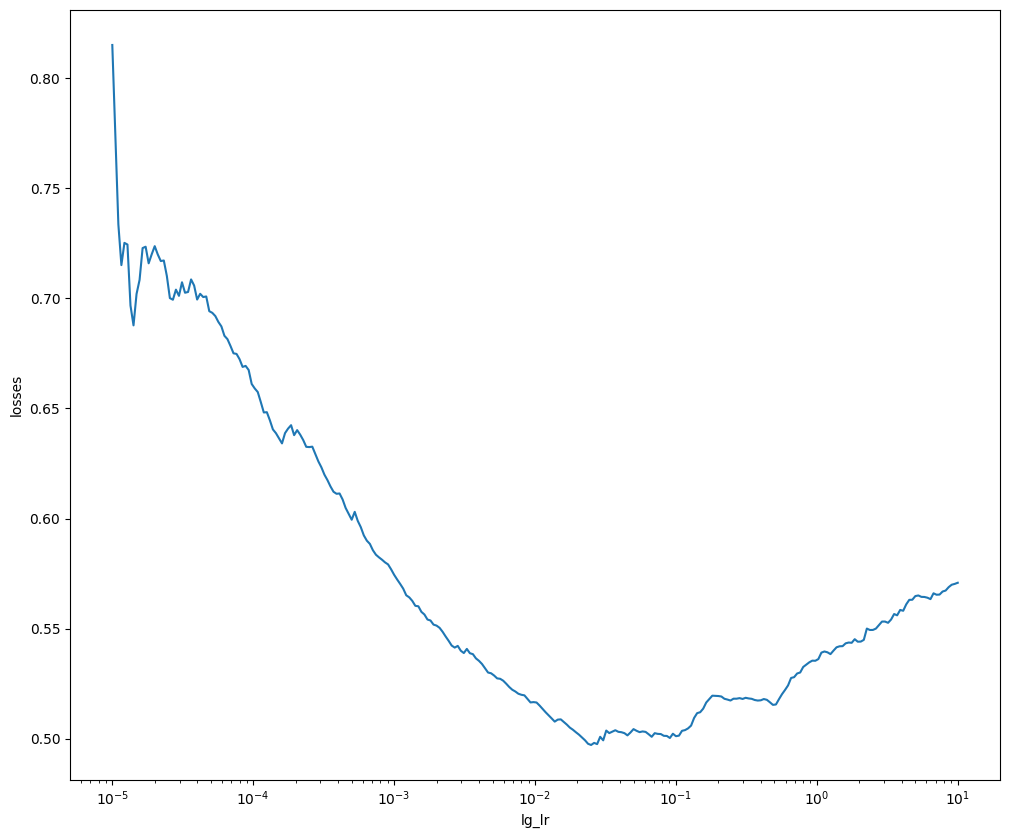

In [ ]:
# plot loss vs learning rate
f1, ax1 = plt.subplots(figsize=(12,10))
ax1.plot(lg_lr, losses)
ax1.set_xscale('log')
ax1.set_xlabel('lg_lr')
ax1.set_ylabel('losses')
plt.show()

In [ ]:
# define the model and train with scheduler
torch.manual_seed(42)
epochs = 5
optimiser = torch.optim.SGD(model.parameters(),
                                 lr=0.01, momentum=0.95,
                                 weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimiser,
                                                max_lr = 1e-1,
                                                steps_per_epoch=len(train_loader),
                                                epochs=epochs, pct_start=0.43, div_factor=10, final_div_factor=1000,
                                                three_phase=True)

In [ ]:
train(model, optimiser, scheduler, epochs)

/usr/local/lib/python3.10/dist-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)


epoch: 0, mb: 25, train cost: 0.5630, val cost: 0.4862,train acc: 0.7406, val acc: 0.8228,dice: 0.6503758430480957, iou: 0.48189404606819153
epoch: 0, mb: 50, train cost: 0.5045, val cost: 0.4533,train acc: 0.8020, val acc: 0.8565,dice: 0.7563979029655457, iou: 0.6082314252853394
epoch: 0, mb: 75, train cost: 0.4847, val cost: 0.4423,train acc: 0.8230, val acc: 0.8676,dice: 0.7912235856056213, iou: 0.654565691947937
epoch: 0, mb: 100, train cost: 0.4675, val cost: 0.4401,train acc: 0.8407, val acc: 0.8699,dice: 0.7623584866523743, iou: 0.615976870059967
epoch: 0, mb: 125, train cost: 0.4600, val cost: 0.4140,train acc: 0.8486, val acc: 0.8960,dice: 0.843968391418457, iou: 0.7300565242767334
epoch: 0, mb: 150, train cost: 0.4572, val cost: 0.4191,train acc: 0.8516, val acc: 0.8907,dice: 0.834796130657196, iou: 0.7164378762245178
epoch: 0, mb: 175, train cost: 0.4539, val cost: 0.4314,train acc: 0.8550, val acc: 0.8780,dice: 0.8262438178062439, iou: 0.7039313912391663
epoch: 0, mb: 200, 

torch.Size([3, 224, 224])


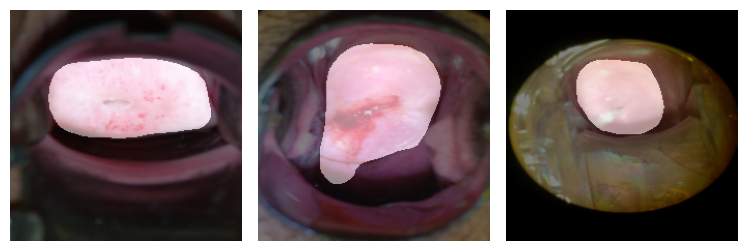

In [ ]:
imgs_val, masks_val = next(iter(val_loader))
imgs_val = imgs_val.to(device, dtype=torch.float32)
model = model.to(device)
with torch.no_grad():
    scores = model(imgs_val)
    preds = torch.argmax(scores, dim=1).float()

imgs_val = imgs_val.cpu()
preds = preds.cpu()
print(preds.shape)
plot_mini_bacth(imgs_val, preds.unsqueeze(1))

In [ ]:
test_set = Colposcopia_Dataset(TEST_PATH, img_transforms=transform_data)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True)

torch.Size([3, 224, 224])


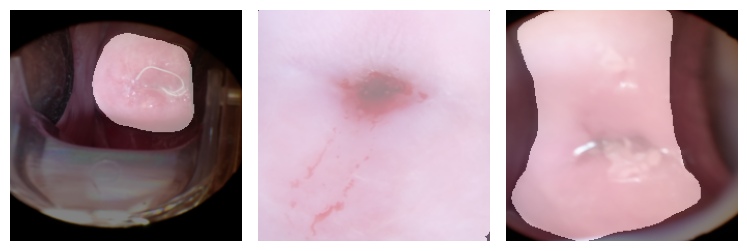

In [ ]:
imgs_test = next(iter(test_loader))
imgs_test = imgs_test.to(device, dtype=torch.float32)
model = model.to(device)
with torch.no_grad():
    scores = model(imgs_test)
    preds = torch.argmax(scores, dim=1).float()

imgs_test = imgs_test.cpu()
preds = preds.cpu()
print(preds.shape)
plot_mini_bacth(imgs_test, preds.unsqueeze(1))